# Imports

In [2]:
import pandas as pd
#pd.options.plotting.backend = "plotly"
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from utils import * # We've added all the functions from the last BLU to the utils.py 

# Explore the data

In [4]:
data = pd.read_csv("data/data.csv")
data.head(5)

,date,power,exog
0,2020-09-20 00:00:00,976.930,11.805
1,2020-09-20 01:00:00,952.705,11.446
2,2020-09-20 02:00:00,928.813,11.218
3,2020-09-20 03:00:00,984.234,11.025
4,2020-09-20 04:00:00,1002.113,11.196


Variables:
- date: date and hour
- power: power readings at each hour, which is what you want to predict
- exog: wind speed forecast, which is the exogenous data that may be useful to make your predictions

First we read the data and make the date our index.

In [6]:
df = pd.read_csv("data/data.csv", index_col="date", parse_dates=True)
df = df.sort_index()

In [7]:
df.head(5)

,power,exog
date,,
2020-09-20 00:00:00,976.930,11.805
2020-09-20 01:00:00,952.705,11.446
2020-09-20 02:00:00,928.813,11.218
2020-09-20 03:00:00,984.234,11.025
2020-09-20 04:00:00,1002.113,11.196


In [8]:
df.tail(5)

,power,exog
date,,
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535
2023-10-15 22:00:00,NaN,10.031
2023-10-15 23:00:00,NaN,9.464


The power values in the last 168 entries (last 7 days) is empty as we want to predict these ones.

Check if we have duplicates

In [9]:
df[df.index.duplicated()]

,power,exog
date,,


Check if the dataset have rows corresponding to all timestamps

In [10]:
start_date = df.index.min()
end_date = df.index.max() 
print(f"It starts at {start_date} and ends at {end_date}")

It starts at 2020-09-20 00:00:00 and ends at 2023-10-15 23:00:00


In [11]:
expected_range = pd.date_range(start=start_date, end=end_date, freq='D') 

missing_timestamps = expected_range[~expected_range.isin(df.index)]

if len(missing_timestamps) == 0:
    print("All timestamps are present in the DataFrame.")
else:
    print("Missing timestamps:")
    print(missing_timestamps)

All timestamps are present in the DataFrame.


So from when to when are we trying to predict?

In [12]:
last_168_index = df.tail(168).index
min_index = last_168_index.min()
max_index = last_168_index.max()

print("From:", min_index, "to", max_index)

From: 2023-10-09 00:00:00 to 2023-10-15 23:00:00


Let's see the range of power values

In [13]:
power_min = df.power.min()
power_max = df.power.max() 
print(f"Power has a minimum value of {power_min} and a maximum value of {power_max}")

Power has a minimum value of 0.0 and a maximum value of 1192.596


Let's see the range of the wind speed (exog) values

In [14]:
speed_min = df.exog.min()
speed_max = df.exog.max() 
print(f"Wind speed has a minimum value of {speed_min} and a maximum value of {speed_max}")

Wind speed has a minimum value of 0.088 and a maximum value of 31.143


Let's see if we have missing values in the power and exog columns.

In [15]:
if df['exog'].isna().any():
    missing_values_count = df['exog'].isna().sum()
    missing_values_indices = df[df['exog'].isna()].index
    print("Number of missing values in the 'exog' column:", missing_values_count)
    print("In the indexes:", missing_values_indices)
    df['date'] = df.index.date

else:
    print("The 'exog' column does not have any missing values.")

Number of missing values in the 'exog' column: 259
In the indexes: DatetimeIndex(['2020-10-16 07:00:00', '2020-10-16 08:00:00',
               '2020-12-11 07:00:00', '2020-12-11 08:00:00',
               '2020-12-11 10:00:00', '2020-12-11 11:00:00',
               '2020-12-13 03:00:00', '2020-12-13 06:00:00',
               '2020-12-26 11:00:00', '2021-01-20 03:00:00',
               ...
               '2022-12-06 08:00:00', '2022-12-06 09:00:00',
               '2022-12-06 10:00:00', '2022-12-06 11:00:00',
               '2022-12-06 12:00:00', '2022-12-06 13:00:00',
               '2022-12-06 14:00:00', '2022-12-06 15:00:00',
               '2022-12-06 16:00:00', '2022-12-06 17:00:00'],
              dtype='datetime64[ns]', name='date', length=259, freq=None)


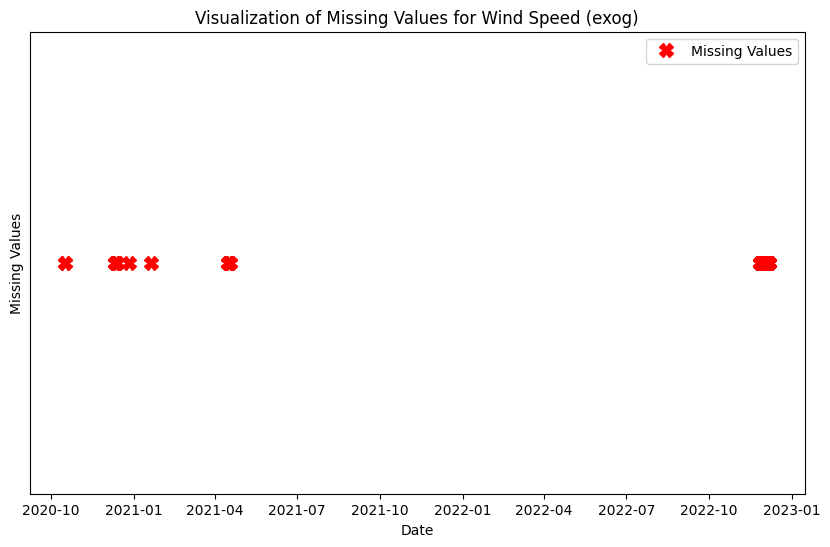

In [16]:
import matplotlib.pyplot as plt

# Highlight missing values
if df['exog'].isna().any():
    missing_values_indices = df[df['exog'].isna()].index

    # Plotting missing values only
    plt.figure(figsize=(10, 6))
    plt.plot(missing_values_indices, [0] * len(missing_values_indices), marker='X', markersize=10, color='red', linestyle='', label='Missing Values')

    plt.title('Visualization of Missing Values for Wind Speed (exog)')
    plt.xlabel('Date')
    plt.ylabel('Missing Values')
    plt.legend()
    plt.grid(False)
    plt.yticks([])
    plt.show()
else:
    print("No missing values found in the 'exog' column.")


In [17]:
if df['power'].isna().any():
    missing_values_count = df['power'].isna().sum()
    relevant_missing = missing_values_count - 168
    missing_values_indices = df[df['power'].isna()].index[:-168]
    print("Number of missing values in the 'power' column excluding the last 168 entries:", relevant_missing)
    print("In the indexes:", missing_values_indices)
else:
    print("The 'power' column does not have any missing values.")

Number of missing values in the 'power' column excluding the last 168 entries: 51
In the indexes: DatetimeIndex(['2021-11-15 00:00:00', '2021-11-15 01:00:00',
               '2023-06-03 23:00:00', '2023-06-04 00:00:00',
               '2023-06-04 01:00:00', '2023-06-04 02:00:00',
               '2023-06-04 03:00:00', '2023-06-04 04:00:00',
               '2023-06-04 05:00:00', '2023-06-04 06:00:00',
               '2023-06-04 07:00:00', '2023-06-04 08:00:00',
               '2023-06-04 09:00:00', '2023-06-04 10:00:00',
               '2023-06-04 11:00:00', '2023-06-04 12:00:00',
               '2023-06-04 13:00:00', '2023-06-04 14:00:00',
               '2023-06-04 15:00:00', '2023-06-04 16:00:00',
               '2023-06-04 17:00:00', '2023-06-04 18:00:00',
               '2023-06-04 19:00:00', '2023-06-04 20:00:00',
               '2023-06-04 21:00:00', '2023-06-04 22:00:00',
               '2023-08-16 23:00:00', '2023-09-16 23:00:00',
               '2023-09-17 00:00:00', '2023-09-1

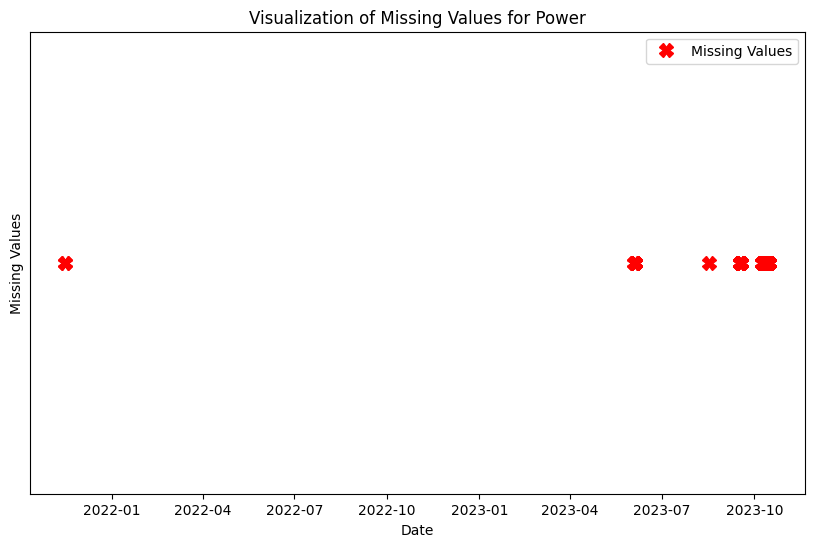

In [18]:
# Highlight missing values
if df['power'].isna().any():
    missing_values_indices = df[df['power'].isna()].index

    # Plotting missing values only
    plt.figure(figsize=(10, 6))
    plt.plot(missing_values_indices, [0] * len(missing_values_indices), marker='X', markersize=10, color='red', linestyle='', label='Missing Values')

    plt.title('Visualization of Missing Values for Power')
    plt.xlabel('Date')
    plt.ylabel('Missing Values')
    plt.legend()
    plt.grid(False)
    plt.yticks([])
    plt.show()
else:
    print("No missing values found in the 'power' column.")


So we have 51 empty values in power and 219 empty values in the wind speed forecast.

Let's input some values to the exog and power, except when in the last 168 entries where we want power to still be empty.

In [20]:
df = pd.read_csv("data/data.csv", index_col="date", parse_dates=True)
df = df.sort_index()

In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() 
    
data_imputed = imputer.fit_transform(df)

# Create DataFrame with imputed values for all but the last 168 rows
df_imputed = pd.DataFrame(imputer.fit_transform(df.iloc[:-168]), index=df.iloc[:-168].index, columns=df.columns)

# Concatenate imputed data with the last 168 rows
df_final = pd.concat([df_imputed, df.iloc[-168:]])

# df_imputed.exog.plot()
# plt.ylabel('exog')
# plt.show()

In [22]:
df_final.head(5)

,power,exog
date,,
2020-09-20 00:00:00,976.930,11.805
2020-09-20 01:00:00,952.705,11.446
2020-09-20 02:00:00,928.813,11.218
2020-09-20 03:00:00,984.234,11.025
2020-09-20 04:00:00,1002.113,11.196


In [23]:
df_final.tail(5)

,power,exog
date,,
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535
2023-10-15 22:00:00,NaN,10.031
2023-10-15 23:00:00,NaN,9.464


In [24]:
if df_final['power'].isna().any():
    missing_values_count = df_final['power'].isna().sum()
    relevant_missing = missing_values_count - 168
    missing_values_indices = df_final[df_final['power'].isna()].index[:-168]
    print("Number of missing values in the 'power' column excluding the last 168 entries:", relevant_missing)
    print("In the indexes:", missing_values_indices)
else:
    print("The 'power' column does not have any missing values.")

Number of missing values in the 'power' column excluding the last 168 entries: 0
In the indexes: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [25]:
if df_final['exog'].isna().any():
    missing_values_count = df_final['exog'].isna().sum()
    missing_values_indices = df_final[df_final['exog'].isna()].index
    print("Number of missing values in the 'exog' column:", missing_values_count)
    print("In the indexes:", missing_values_indices)
    df_final['date'] = df_final.index.date
else:
    print("The 'exog' column does not have any missing values.")

The 'exog' column does not have any missing values.


## Baseline

### Baseline using the values of the previous 7 days

Let's create a first baseline.

Let's start by adding lagged features to our data. We want to make predictions for the next 7 days and each day has 24 hours so 24*7, which are the 168 values that we are missing.

In [26]:
df_baseline = build_exog_features(df_final, 24*7)

In [27]:
df_baseline.head(5)

,power,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead159,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168
date,,,,,,,,,,,,,,,,,,,,,
2020-09-20 00:00:00,976.930,11.805,11.446,11.218,11.025,11.196,11.414,11.382,10.974,10.505,...,19.099,20.280,20.287,19.097,19.163,18.757,16.223,17.853,16.920,14.621
2020-09-20 01:00:00,952.705,11.446,11.218,11.025,11.196,11.414,11.382,10.974,10.505,9.757,...,20.280,20.287,19.097,19.163,18.757,16.223,17.853,16.920,14.621,20.358
2020-09-20 02:00:00,928.813,11.218,11.025,11.196,11.414,11.382,10.974,10.505,9.757,8.988,...,20.287,19.097,19.163,18.757,16.223,17.853,16.920,14.621,20.358,20.452
2020-09-20 03:00:00,984.234,11.025,11.196,11.414,11.382,10.974,10.505,9.757,8.988,8.428,...,19.097,19.163,18.757,16.223,17.853,16.920,14.621,20.358,20.452,15.867
2020-09-20 04:00:00,1002.113,11.196,11.414,11.382,10.974,10.505,9.757,8.988,8.428,8.428,...,19.163,18.757,16.223,17.853,16.920,14.621,20.358,20.452,15.867,18.657


Now that we have all thelagged features, let's create a new column called baseline. This will make the value at each row in the 'baseline' column represent the power reading from 7 days ago. The purpose of creating this 'baseline' column could be to establish a simple benchmark to compare the performance of predictive models against simpler methods like persistence forecasting (using previous values as predictions).

In [28]:
df_baseline["baseline"] = df_baseline.power.shift(24*7)

In [29]:
df_baseline.head(5)

,power,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168,baseline
date,,,,,,,,,,,,,,,,,,,,,
2020-09-20 00:00:00,976.930,11.805,11.446,11.218,11.025,11.196,11.414,11.382,10.974,10.505,...,20.280,20.287,19.097,19.163,18.757,16.223,17.853,16.920,14.621,NaN
2020-09-20 01:00:00,952.705,11.446,11.218,11.025,11.196,11.414,11.382,10.974,10.505,9.757,...,20.287,19.097,19.163,18.757,16.223,17.853,16.920,14.621,20.358,NaN
2020-09-20 02:00:00,928.813,11.218,11.025,11.196,11.414,11.382,10.974,10.505,9.757,8.988,...,19.097,19.163,18.757,16.223,17.853,16.920,14.621,20.358,20.452,NaN
2020-09-20 03:00:00,984.234,11.025,11.196,11.414,11.382,10.974,10.505,9.757,8.988,8.428,...,19.163,18.757,16.223,17.853,16.920,14.621,20.358,20.452,15.867,NaN
2020-09-20 04:00:00,1002.113,11.196,11.414,11.382,10.974,10.505,9.757,8.988,8.428,8.428,...,18.757,16.223,17.853,16.920,14.621,20.358,20.452,15.867,18.657,NaN


In [30]:
df_baseline.tail(5)

,power,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168,baseline
date,,,,,,,,,,,,,,,,,,,,,
2023-10-15 19:00:00,NaN,10.820,10.619,9.535,10.031,9.464,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.124
2023-10-15 20:00:00,NaN,10.619,9.535,10.031,9.464,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,699.824
2023-10-15 21:00:00,NaN,9.535,10.031,9.464,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,922.044
2023-10-15 22:00:00,NaN,10.031,9.464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,897.264
2023-10-15 23:00:00,NaN,9.464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,797.614


Let's divide the data into train, validation and test.

In [31]:
train = df_baseline.iloc[:-24*7*2] # excluding the data for the last two weeks
val = df_baseline.iloc[-24*7*2:-24*7] # two weeks just before the test set
train_val = df_baseline.iloc[:-24*7]  # excluding the data for the last week
test = df_baseline.iloc[-24*7:] # last week

Let's calculate the MAE using the power column as the real value and the baseline column we created as the predictions.

In [32]:
val_mae = mean_absolute_error(val["power"],val["baseline"])
print(val_mae)

516.824517857143


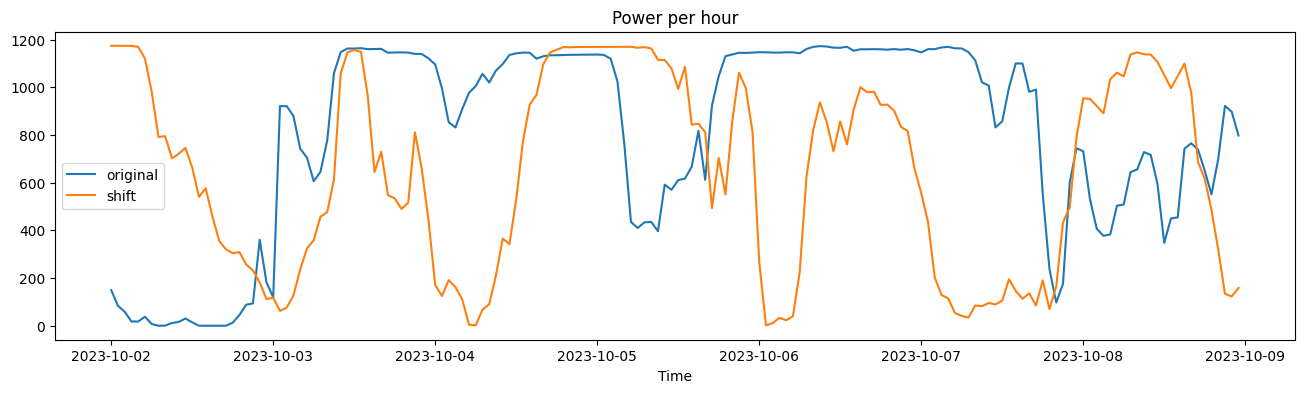

In [33]:
plt.plot(val["power"], label='original')
plt.plot(val["baseline"], label='shift')
plt.xlabel('Time')
plt.title('Power per hour')
plt.legend()
plt.show()

### Baseline using SARIMAX

In [34]:
train_power = df_final['power'][:-24*7*2]
train_exog = df_final['exog'][:-24*7*2]

val_power = df_final['power'][-24*7*2:-24*7]
val_exog = df_final['exog'][-24*7*2:-24*7]

test_power = df_final['power'][-24*7:]
test_exog = df_final['exog'][-24*7:]

train_log = train_power.map(np.log)
test_log = test_power.map(np.log)

Let's see if there is any correlation per hour.

Text(0.5, 0, 'Lag')

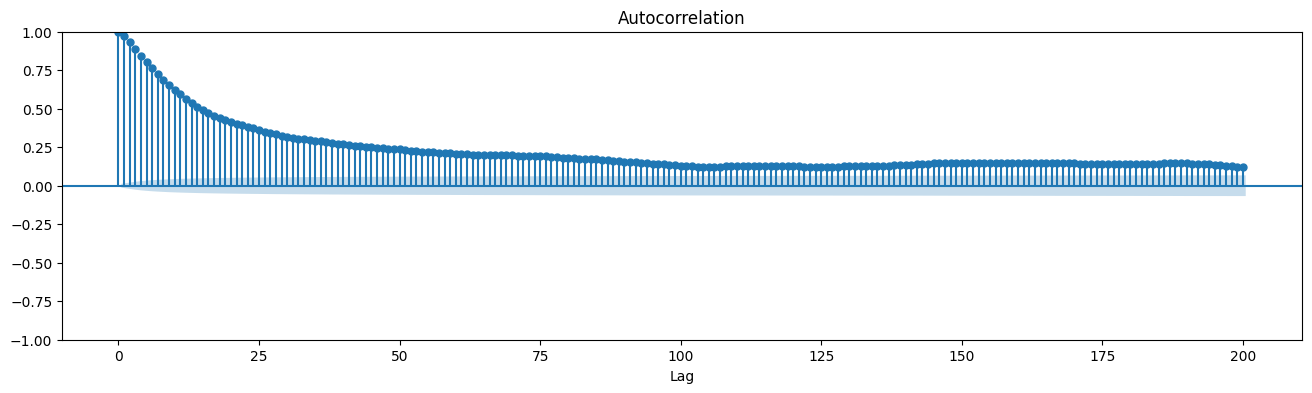

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_power, lags=200, alpha=.05)
plt.xlabel('Lag')

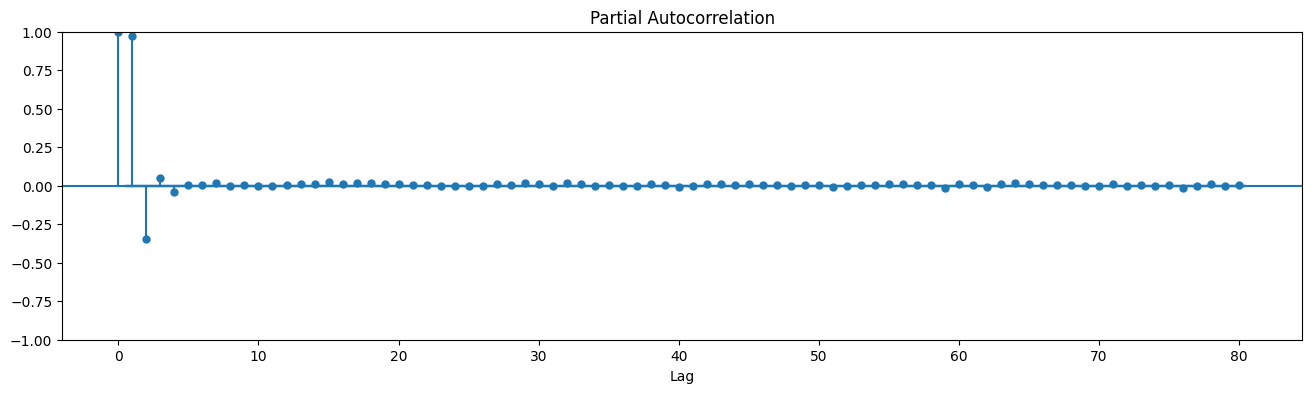

In [36]:
plot_pacf(train_power, alpha=.05, lags=80)  
plt.xlabel('Lag')
plt.show()

This shows a bigger correlation with the hour just before what makes sense as the wind speed of one hour tends to be similar to the one of the previous hour.

What about per day?

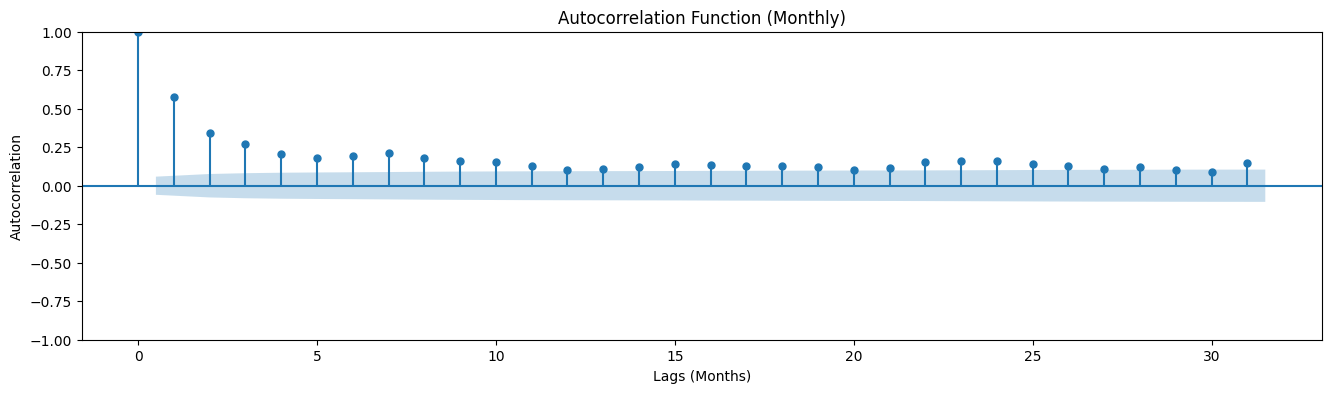

In [37]:
day_power = train_power.resample('D').mean()  # or sum(), or any other aggregation function

# Plot the ACF
plot_acf(day_power)  # Adjust the number of lags as needed
plt.xlabel('Lags (Months)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (Monthly)')
plt.show()

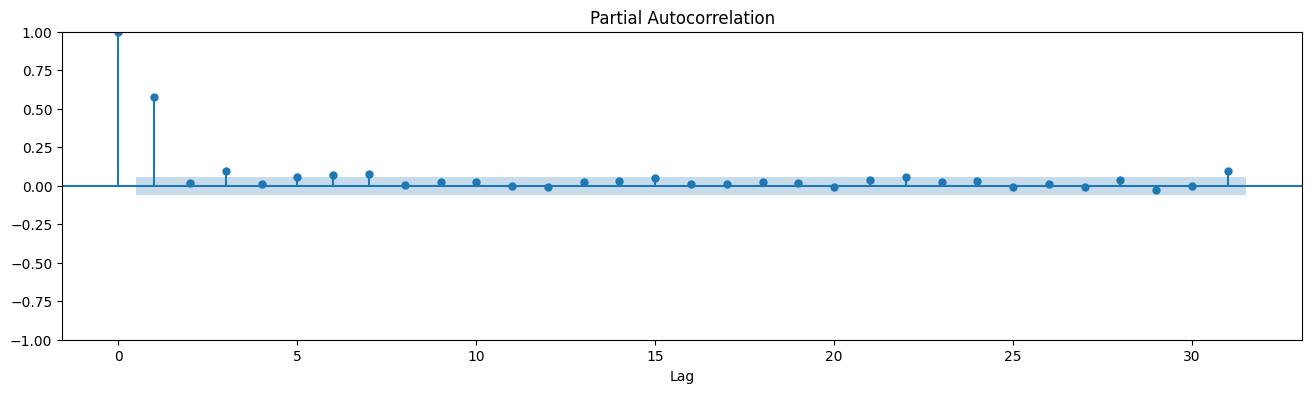

In [38]:
plot_pacf(day_power, alpha=.05)  
plt.xlabel('Lag')
plt.show()

What about per week?

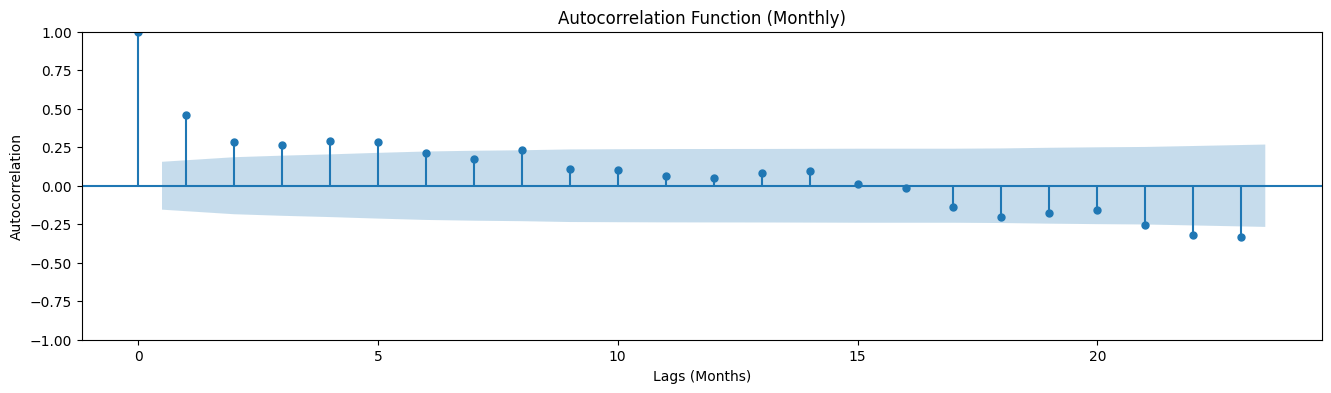

In [39]:
weekly_power = train_power.resample('W').mean()  # or sum(), or any other aggregation function

# Plot the ACF
plot_acf(weekly_power)  # Adjust the number of lags as needed
plt.xlabel('Lags (Months)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (Monthly)')
plt.show()

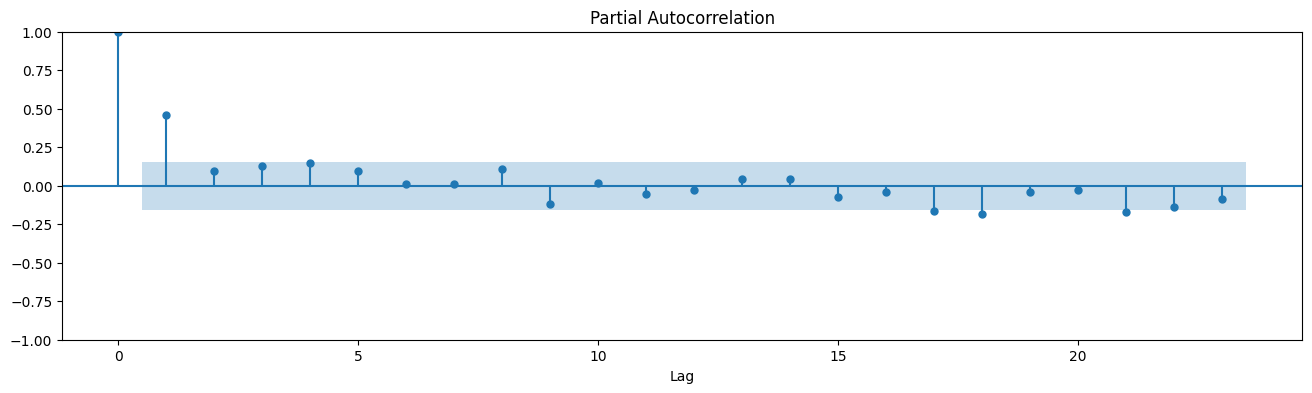

In [40]:
plot_pacf(weekly_power, alpha=.05)  
plt.xlabel('Lag')
plt.show()

What about per month?

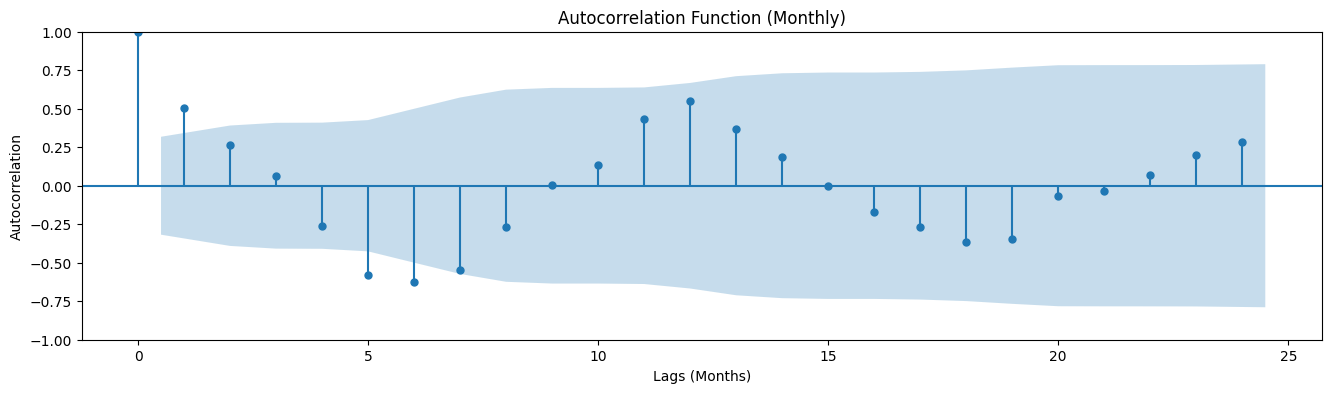

In [41]:
monthly_power = train_power.resample('M').mean()  # or sum(), or any other aggregation function

# Plot the ACF
plot_acf(monthly_power, lags=24)  # Adjust the number of lags as needed
plt.xlabel('Lags (Months)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (Monthly)')
plt.show()


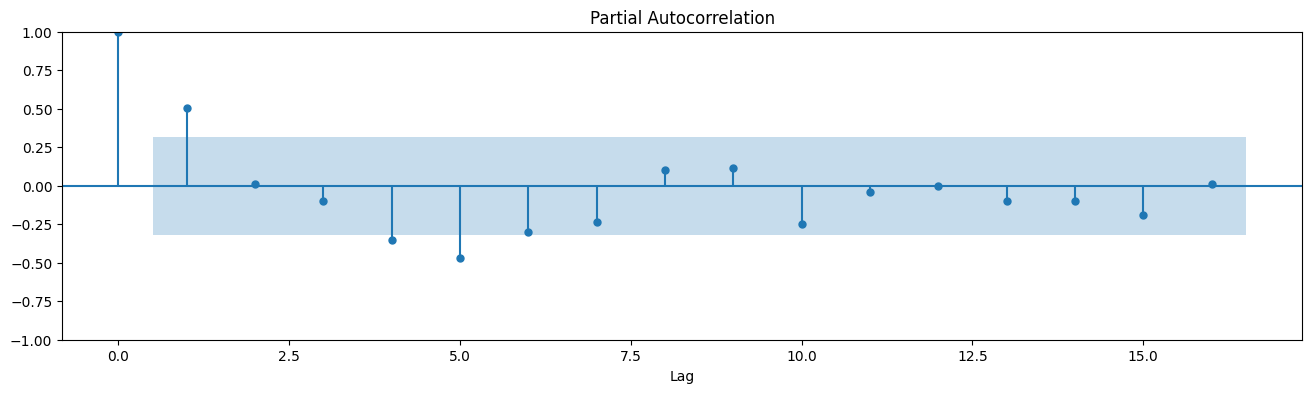

In [42]:
plot_pacf(monthly_power, alpha=.05)  
plt.xlabel('Lag')
plt.show()

In [ ]:
from pmdarima.pipeline import Pipeline
import pmdarima as pm

seasonal_period = 5 * 30 * 24  # Assuming 5 months seasonality

sarimax_pipeline_exog = Pipeline([
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=seasonal_period, 
                           maxiter=10,
                          )
    )
])

sarimax_pipeline_exog.fit(train_power.to_frame(),train_exog.to_frame())

Performing stepwise search to minimize aic


In [ ]:
predictions = sarimax_pipeline_exog.predict(n_periods=24*7, exogenous=val_exog)

mse = mean_absolute_error(predictions, val_power)

In [ ]:
import pmdarima as pm

sarimax = pm.AutoARIMA(trace=True, suppress_warnings=True, m=24)

sarimax_forecast_one_step_refit = []
sarimax.fit(train_power[:5000].to_frame(), train_exog[:5000].to_frame())

for i in range(len(test_power)):
    next_step_forecast = sarimax.predict(n_periods=1, exogenous=test_exog.to_frame()[i:i+1])[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax.update(test_power.to_frame()[i:i+1], exogenous=test_exog.to_frame()[i:i+1])

print(np.round(sarimax_forecast_one_step_refit, 1))


Let's try linear regression

In [ ]:
predictions = predict_n_periods(series_=train_power.to_frame(), 
                  n_periods=len(test_power.to_frame()), 
                  model=LinearRegression(), 
                  holidays= False, 
                  month= False,
                  num_periods_diffed= 0,
                  num_periods_lagged= 5, 
                  rolling= [], 
                  weekday= False,
                  target="power"
                  )

In [ ]:
predictions

In [ ]:
mean_absolute_error(test_power.to_frame(),predictions)

In [ ]:
plt.plot(test_power.to_frame()["power"], label='original')
plt.plot(predictions, label='shift')
plt.xlabel('Time')
plt.title('Power per hour')
plt.legend()
plt.show()

Let's try gradient boosting regressor

In [ ]:
predictions = predict_n_periods(series_=train_power.to_frame(), 
                  n_periods=len(test_power.to_frame()), 
                  model=GradientBoostingRegressor(n_estimators=20, random_state=10), 
                  holidays= False, 
                  month= False,
                  num_periods_diffed= 0,
                  num_periods_lagged= 5, 
                  rolling= [], 
                  weekday= False,
                  target="power"
                  )

In [ ]:
mean_absolute_error(test_power.to_frame(),predictions)

In [ ]:
predictions = predict_n_periods(series_=train_power.to_frame(), 
                  n_periods=len(val_power.to_frame()), 
                  model=GradientBoostingRegressor(n_estimators=20, random_state=10), 
                  holidays= False, 
                  month= True,
                  num_periods_diffed= 0,
                  num_periods_lagged= 5, 
                  rolling= [], 
                  weekday= False,
                  target="power"
                  )

In [ ]:
mean_absolute_error(val_power.to_frame(),predictions)

In [ ]:
predictions_with_index = pd.Series(predictions, index=val_power.index)
predictions_with_index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_power.index, val_power.values, label='Actual Values', color='blue')
plt.plot(predictions_with_index.index, predictions_with_index.values, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.show()

In [ ]:
predictions = predict_n_periods(series_=train_power.to_frame(), 
                  n_periods=len(val_power.to_frame()), 
                  model=GradientBoostingRegressor(n_estimators=20, random_state=10), 
                  holidays= False, 
                  month= True,
                  num_periods_diffed= 0,
                  num_periods_lagged= 10, 
                  rolling= [], 
                  weekday= False,
                  target="power"
                  )

In [ ]:
mean_absolute_error(val_power.to_frame(),predictions)

In [ ]:
predictions_with_index = pd.Series(predictions, index=val_power.index)
predictions_with_index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_power.index, val_power.values, label='Actual Values', color='blue')
plt.plot(predictions_with_index.index, predictions_with_index.values, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.show()

In [ ]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(val), 
                  model=GradientBoostingRegressor(n_estimators=20, random_state=10), 
                  holidays= False, 
                  month= True,
                  num_periods_diffed= 5,
                  num_periods_lagged= 5, 
                  rolling= [], 
                  weekday= False,
                  target="power"
                  )

In [ ]:
mean_absolute_error(val_power.to_frame(),predictions)

In [ ]:
predictions_with_index = pd.Series(predictions, index=val_power.index)
predictions_with_index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_power.index, val_power.values, label='Actual Values', color='blue')
plt.plot(predictions_with_index.index, predictions_with_index.values, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid

param_grid = {
    'model': [LinearRegression(), GradientBoostingRegressor(n_estimators=20, random_state=10), RandomForestRegressor(n_estimators=20, random_state=10), SVR()],
    'num_periods_lagged': [3, 7, 14, 26],
    'num_periods_diffed': [0, 1, 7, 15],
    'weekday': [False],
    'month': [True, False],
    'holidays': [False],
    'rolling': [[]]  # Empty list as we don't want rollings
}


grid = ParameterGrid(param_grid)

error_lst = []

for params in tqdm(grid):
   predictions = predict_n_periods(series_=train_power.to_frame(), 
                     n_periods=len(val_power.to_frame()), 
                     model=params['model'], 
                     num_periods_lagged=params['num_periods_lagged'],
                     num_periods_diffed=params['num_periods_diffed'],
                     weekday=params['weekday'],
                     month=params['month'],
                     rolling=params['rolling'],
                     target="power"
                   )

   error_lst.append(mean_absolute_error(val_power.to_frame(),predictions))

    
best_params_index = pd.Series(error_lst).idxmin()
best_params = list(grid)[best_params_index]
#best_params = list(grid)[0]

print("Best parameters:", best_params)

In [ ]:
predictions = predict_n_periods(series_=train_power.to_frame(), 
                  n_periods=len(val_power.to_frame()), 
                  model=LinearRegression(), 
                  holidays= False, 
                  month= False,
                  num_periods_diffed= 0,
                  num_periods_lagged= 3, 
                  rolling= [], 
                  weekday= False,
                  target="wp"
                  )
val_mae = mean_absolute_error(val_power.to_frame(),predictions)
val_mae